In [1]:
import os

# Configurar directorio de trabajo
target_dir = os.getcwd() if 'cnn-cards' in os.getcwd().lower() else './CNN-Cards'

if os.path.isdir(target_dir):
    os.chdir(target_dir)
print(f'Directorio actual: {os.getcwd()}')

DATA_PATH = './Datasets/Cards/'

Directorio actual: /tf/CNN-Cards


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Global variables
SIZE = 224
NUM_CLASSES = 13  # A, 2-10, J, Q, K
SUIT_CLASSES = 4  # clubs, diamonds, hearts, spades
EPOCHS = 100
PATIENCE_ES = 25
BATCH_SIZE = 128

path_models = 'Models'
path_results = 'Results'

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU disponible: {tf.config.list_physical_devices("GPU")}')

2025-12-05 21:41:24.028888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-05 21:41:24.029013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-05 21:41:24.076801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Crear generador de datos personalizado

Parseamos las etiquetas del nombre de las carpetas (ej: "ace of clubs" -> num=ace, suit=clubs)

In [3]:
# Mapeo de nombres a indices
NUM_MAP = {
    'ace': 0, 'two': 1, 'three': 2, 'four': 3, 'five': 4,
    'six': 5, 'seven': 6, 'eight': 7, 'nine': 8, 'ten': 9,
    'jack': 10, 'queen': 11, 'king': 12
}

SUIT_MAP = {
    'clubs': 0, 'diamonds': 1, 'hearts': 2, 'spades': 3
}

# Inversos para visualizacion
NUM_NAMES = {v: k for k, v in NUM_MAP.items()}
SUIT_NAMES = {v: k for k, v in SUIT_MAP.items()}

def parse_card_label(folder_name):
    """Extrae numero y palo del nombre de la carpeta"""
    # Formato: "ace of clubs", "two of hearts", etc.
    # Joker no tiene palo - lo excluimos
    if 'joker' in folder_name.lower():
        return None, None
    
    parts = folder_name.lower().split(' of ')
    if len(parts) != 2:
        return None, None
    
    num_name, suit_name = parts
    num_idx = NUM_MAP.get(num_name)
    suit_idx = SUIT_MAP.get(suit_name)
    
    return num_idx, suit_idx

# Test
print(parse_card_label('ace of clubs'))  # (0, 0)
print(parse_card_label('king of hearts'))  # (12, 2)
print(parse_card_label('joker'))  # (None, None)

(0, 0)
(12, 2)
(None, None)


In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence

class MultiOutputDataGenerator(Sequence):
    """Generador de datos para modelo multi-output"""
    
    def __init__(self, directory, batch_size=32, target_size=(224, 224), 
                 shuffle=True, augment=False):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        
        # Recopilar todos los archivos de imagen
        self.samples = []
        for folder in Path(directory).iterdir():
            if folder.is_dir():
                num_idx, suit_idx = parse_card_label(folder.name)
                if num_idx is not None and suit_idx is not None:
                    for img_path in folder.glob('*.jpg'):
                        self.samples.append((str(img_path), num_idx, suit_idx))
                    for img_path in folder.glob('*.png'):
                        self.samples.append((str(img_path), num_idx, suit_idx))
        
        print(f'Cargadas {len(self.samples)} imagenes de {directory}')
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.samples) // self.batch_size
    
    def __getitem__(self, idx):
        batch_samples = self.samples[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        X = np.zeros((len(batch_samples), *self.target_size, 3), dtype=np.float32)
        y_num = np.zeros((len(batch_samples), NUM_CLASSES), dtype=np.float32)
        y_suit = np.zeros((len(batch_samples), SUIT_CLASSES), dtype=np.float32)
        
        for i, (img_path, num_idx, suit_idx) in enumerate(batch_samples):
            img = load_img(img_path, target_size=self.target_size)
            img_array = img_to_array(img) / 255.0
            
            if self.augment:
                img_array = self._augment(img_array)
            
            X[i] = img_array
            y_num[i, num_idx] = 1.0
            y_suit[i, suit_idx] = 1.0
        
        return X, {'num_output': y_num, 'suit_output': y_suit}
    
    def _augment(self, img):
        """Aplicar augmentacion basica"""
        # Random flip horizontal
        if np.random.random() > 0.5:
            img = np.fliplr(img)
        # Random flip vertical
        if np.random.random() > 0.5:
            img = np.flipud(img)
        # Random brightness
        if np.random.random() > 0.5:
            factor = np.random.uniform(0.9, 1.1)
            img = np.clip(img * factor, 0, 1)
        return img
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.samples)

In [5]:
# Crear generadores
train_gen = MultiOutputDataGenerator(
    DATA_PATH + 'train',
    batch_size=BATCH_SIZE,
    target_size=(SIZE, SIZE),
    shuffle=True,
    augment=True
)

valid_gen = MultiOutputDataGenerator(
    DATA_PATH + 'valid',
    batch_size=BATCH_SIZE,
    target_size=(SIZE, SIZE),
    shuffle=False,
    augment=False
)

test_gen = MultiOutputDataGenerator(
    DATA_PATH + 'test',
    batch_size=BATCH_SIZE,
    target_size=(SIZE, SIZE),
    shuffle=False,
    augment=False
)

Cargadas 7583 imagenes de ./Datasets/Cards/train
Cargadas 260 imagenes de ./Datasets/Cards/valid
Cargadas 260 imagenes de ./Datasets/Cards/test


Shape X: (128, 224, 224, 3)
Shape y_num: (128, 13)
Shape y_suit: (128, 4)


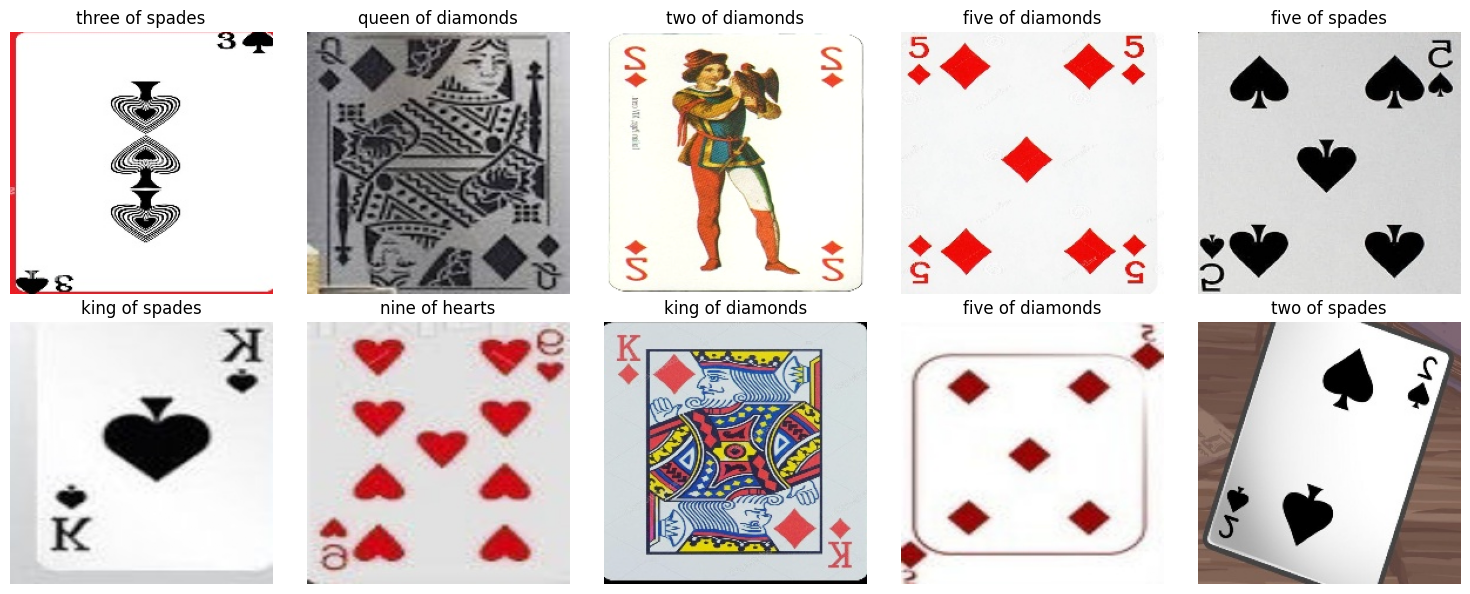

In [6]:
# Verificar un batch
X_sample, y_sample = train_gen[0]
print(f'Shape X: {X_sample.shape}')
print(f'Shape y_num: {y_sample["num_output"].shape}')
print(f'Shape y_suit: {y_sample["suit_output"].shape}')

# Visualizar una muestra
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(X_sample[i])
    num_idx = y_sample['num_output'][i].argmax()
    suit_idx = y_sample['suit_output'][i].argmax()
    ax.set_title(f'{NUM_NAMES[num_idx]} of {SUIT_NAMES[suit_idx]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Construir modelo Multi-Output

In [7]:
def build_multioutput_model(input_shape=(224, 224, 3), num_classes=13, suit_classes=4):
    """Modelo multi-output con backbone MobileNetV2"""
    
    # Backbone compartido
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    # Descongelar ultimas capas
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    
    # Shared hidden layers
    shared = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    shared = Dropout(0.4)(shared)
    shared = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(shared)
    shared = Dropout(0.3)(shared)
    
    # Cabeza para Numero (13 clases)
    num_branch = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(shared)
    num_branch = Dropout(0.2)(num_branch)
    num_output = Dense(num_classes, activation='softmax', name='num_output')(num_branch)
    
    # Cabeza para Palo (4 clases)
    suit_branch = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(shared)
    suit_branch = Dropout(0.2)(suit_branch)
    suit_output = Dense(suit_classes, activation='softmax', name='suit_output')(suit_branch)
    
    model = Model(inputs=inputs, outputs=[num_output, suit_output])
    return model

multioutput_model = build_multioutput_model()
multioutput_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_2[0][0]']             
 tional)                                                                                          
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['mobilenetv2_1.00_224[0][0]']
 GlobalAveragePooling2D)                                                                          
                                                                                              

In [9]:
# Visualizar arquitectura
tf.keras.utils.plot_model(
    multioutput_model, 
    to_file='Results/multioutput_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=100
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Configurar y entrenar

In [10]:
name = 'MultiOutput_NumSuit'

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(path_models, name + '.h5'),
    monitor='val_loss',  # Monitoreamos loss total
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=PATIENCE_ES,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{name}',
    histogram_freq=1
)

callbacks_list = [checkpoint, early_stop, reduce_lr, tensorboard]

In [11]:
# Compilar con pesos para cada salida
multioutput_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'num_output': 'categorical_crossentropy',
        'suit_output': 'categorical_crossentropy'
    },
    loss_weights={
        'num_output': 1.0,  # Numero mas importante (13 clases)
        'suit_output': 0.5  # Palo menos clases, menor peso
    },
    metrics={
        'num_output': 'accuracy',
        'suit_output': 'accuracy'
    }
)

In [12]:
# Entrenar
history = multioutput_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/100


I0000 00:00:1764970977.973245   15458 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/59 [==============================] - ETA: 0s - loss: 3.5676 - num_output_loss: 2.7112 - suit_output_loss: 1.5662 - num_output_accuracy: 0.1249 - suit_output_accuracy: 0.3438
Epoch 1: val_loss improved from inf to 3.00267, saving model to Models/MultiOutput_NumSuit.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 51s 657ms/step - loss: 3.5676 - num_output_loss: 2.7112 - suit_output_loss: 1.5662 - num_output_accuracy: 0.1249 - suit_output_accuracy: 0.3438 - val_loss: 3.0027 - val_num_output_loss: 2.3500 - val_suit_output_loss: 1.1591 - val_num_output_accuracy: 0.1875 - val_suit_output_accuracy: 0.5586 - lr: 1.0000e-04
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 2.8544 - num_output_loss: 2.2273 - suit_output_loss: 1.1080 - num_output_accuracy: 0.2405 - suit_output_accuracy: 0.5097
Epoch 2: val_loss improved from 3.00267 to 2.66461, saving model to Models/MultiOutput_NumSuit.h5
59/59 [==============================] - 31s 518ms/step - loss: 2.8544 - num_output_loss: 2.2273 - suit_output_loss: 1.1080 - num_output_accuracy: 0.2405 - suit_output_accuracy: 0.5097 - val_loss: 2.6646 - val_num_output_loss: 2.1140 - val_suit_output_loss: 0.9551 - val_num_output_accuracy: 0.2734 - val_suit_output_accuracy: 0.6328 - lr: 1.0000e-04
Epoch 3/10

## Visualizar resultados

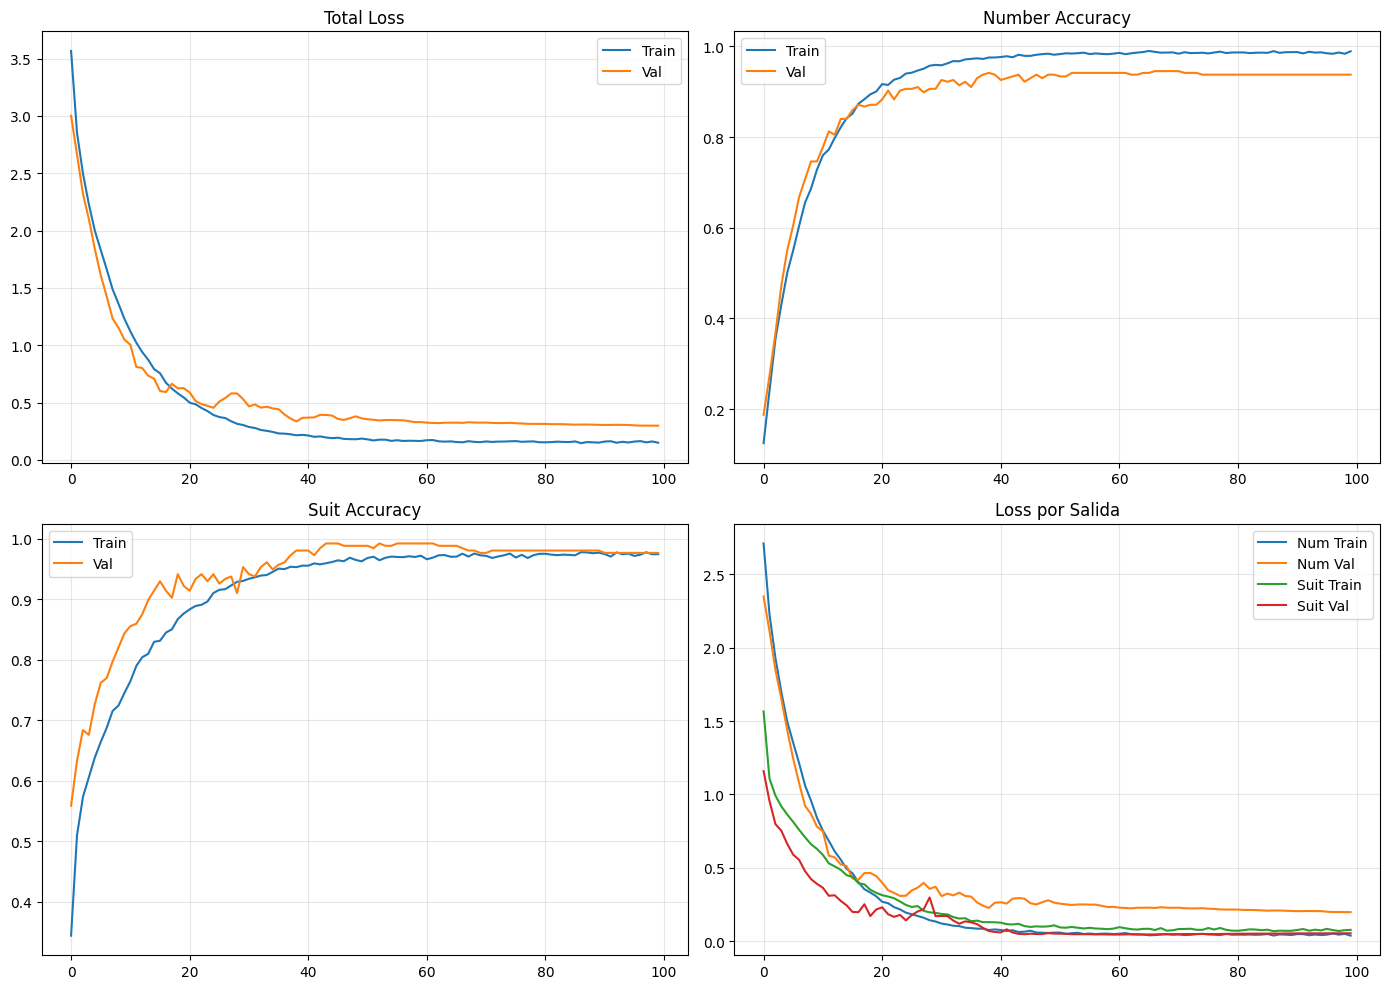

In [13]:
def plot_multioutput_history(h, dir, name):
    history_df = pd.DataFrame(h.history)
    history_df['epoch'] = list(range(len(history_df)))
    history_df.to_csv(os.path.join(dir, name + '.csv'), header=True, index=False)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Loss total
    axes[0, 0].plot(history_df['epoch'], history_df['loss'], label='Train')
    axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], label='Val')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy Numero
    axes[0, 1].plot(history_df['epoch'], history_df['num_output_accuracy'], label='Train')
    axes[0, 1].plot(history_df['epoch'], history_df['val_num_output_accuracy'], label='Val')
    axes[0, 1].set_title('Number Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Accuracy Palo
    axes[1, 0].plot(history_df['epoch'], history_df['suit_output_accuracy'], label='Train')
    axes[1, 0].plot(history_df['epoch'], history_df['val_suit_output_accuracy'], label='Val')
    axes[1, 0].set_title('Suit Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Loss por salida
    axes[1, 1].plot(history_df['epoch'], history_df['num_output_loss'], label='Num Train')
    axes[1, 1].plot(history_df['epoch'], history_df['val_num_output_loss'], label='Num Val')
    axes[1, 1].plot(history_df['epoch'], history_df['suit_output_loss'], label='Suit Train')
    axes[1, 1].plot(history_df['epoch'], history_df['val_suit_output_loss'], label='Suit Val')
    axes[1, 1].set_title('Loss por Salida')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(dir, name + '_curves.png'), dpi=150)
    plt.show()

plot_multioutput_history(history, path_results, name)

## Evaluacion en Test Set

In [14]:
# Cargar mejor modelo
best_model = tf.keras.models.load_model(os.path.join(path_models, name + '.h5'))

# Evaluar
results = best_model.evaluate(test_gen)
print(f'\n=== Resultados en Test Set ===')
print(f'Loss total: {results[0]:.4f}')
print(f'Num Loss: {results[1]:.4f}')
print(f'Suit Loss: {results[2]:.4f}')
print(f'Num Accuracy: {results[3]:.4f}')
print(f'Suit Accuracy: {results[4]:.4f}')

2/2 [==============================] - 2s 343ms/step - loss: 0.3130 - num_output_loss: 0.1972 - suit_output_loss: 0.0857 - num_output_accuracy: 0.9375 - suit_output_accuracy: 0.9648

=== Resultados en Test Set ===
Loss total: 0.3130
Num Loss: 0.1972
Suit Loss: 0.0857
Num Accuracy: 0.9375
Suit Accuracy: 0.9648


In [17]:
# Accuracy combinada (carta correcta = numero Y palo correctos)
def calculate_combined_accuracy(model, generator):
    correct = 0
    total = 0
    
    for i in range(len(generator)):
        X, y = generator[i]
        preds = model.predict(X, verbose=0)
        
        num_pred = preds[0].argmax(axis=1)
        suit_pred = preds[1].argmax(axis=1)
        num_true = y['num_output'].argmax(axis=1)
        suit_true = y['suit_output'].argmax(axis=1)
        
        # Ambos deben ser correctos
        correct += np.sum((num_pred == num_true) & (suit_pred == suit_true))
        total += len(X)
    
    return correct / total

combined_acc = calculate_combined_accuracy(best_model, test_gen)
print(f'\nAccuracy combinada (carta completa): {combined_acc:.4f}')
print(f'Equivalente a 52 clases: {combined_acc:.4f}')


Accuracy combinada (carta completa): 0.9102
Equivalente a 52 clases: 0.9102


4/4 [==============================] - 0s 58ms/step


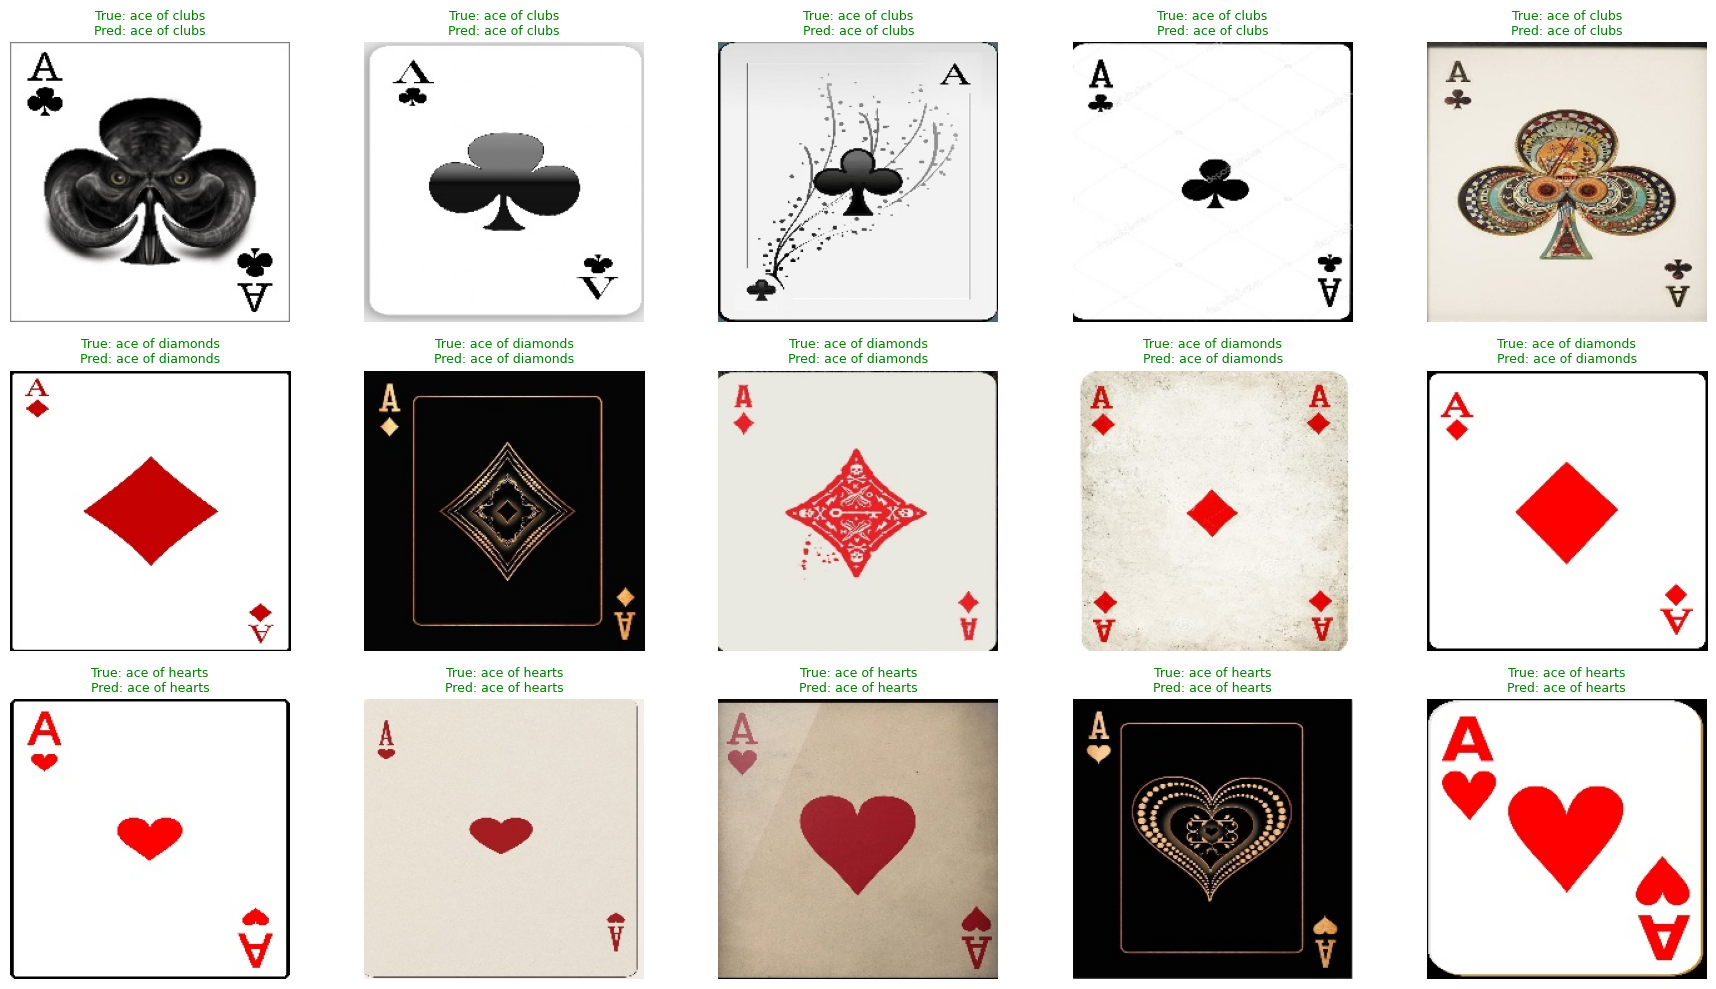

In [18]:
# Visualizar predicciones
X_test, y_test = test_gen[0]
predictions = best_model.predict(X_test)

fig, axes = plt.subplots(3, 5, figsize=(18, 10))
for i in range(15):
    ax = axes[i//5, i%5]
    ax.imshow(X_test[i])
    
    # True labels
    true_num = NUM_NAMES[y_test['num_output'][i].argmax()]
    true_suit = SUIT_NAMES[y_test['suit_output'][i].argmax()]
    
    # Predicted labels
    pred_num = NUM_NAMES[predictions[0][i].argmax()]
    pred_suit = SUIT_NAMES[predictions[1][i].argmax()]
    
    correct = (true_num == pred_num) and (true_suit == pred_suit)
    color = 'green' if correct else 'red'
    
    ax.set_title(f'True: {true_num} of {true_suit}\nPred: {pred_num} of {pred_suit}', 
                 color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(path_results, name + '_predictions.png'), dpi=150)
plt.show()

## Confusion Matrices por salida

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Recopilar todas las predicciones
all_num_true, all_num_pred = [], []
all_suit_true, all_suit_pred = [], []

for i in range(len(test_gen)):
    X, y = test_gen[i]
    preds = best_model.predict(X, verbose=0)
    
    all_num_true.extend(y['num_output'].argmax(axis=1))
    all_num_pred.extend(preds[0].argmax(axis=1))
    all_suit_true.extend(y['suit_output'].argmax(axis=1))
    all_suit_pred.extend(preds[1].argmax(axis=1))

# Convertir a nombres
num_names_list = [NUM_NAMES[i] for i in range(NUM_CLASSES)]
suit_names_list = [SUIT_NAMES[i] for i in range(SUIT_CLASSES)]

In [22]:
# Classification report para Numero
print('=== Classification Report - NUMERO ===')
print(classification_report(
    [NUM_NAMES[i] for i in all_num_true],
    [NUM_NAMES[i] for i in all_num_pred],
    target_names=num_names_list
))

=== Classification Report - NUMERO ===
              precision    recall  f1-score   support

         ace       0.95      1.00      0.98        20
         two       0.91      1.00      0.95        20
       three       0.81      0.85      0.83        20
        four       1.00      0.80      0.89        20
        five       0.95      1.00      0.98        20
         six       1.00      0.95      0.97        20
       seven       1.00      0.90      0.95        20
       eight       0.95      1.00      0.98        20
        nine       0.95      1.00      0.98        20
         ten       1.00      0.95      0.97        20
        jack       1.00      0.95      0.97        20
       queen       0.79      0.95      0.86        20
        king       0.93      0.81      0.87        16

    accuracy                           0.94       256
   macro avg       0.94      0.94      0.94       256
weighted avg       0.94      0.94      0.94       256



In [23]:
# Classification report para Palo
print('=== Classification Report - PALO ===')
print(classification_report(
    [SUIT_NAMES[i] for i in all_suit_true],
    [SUIT_NAMES[i] for i in all_suit_pred],
    target_names=suit_names_list
))

=== Classification Report - PALO ===
              precision    recall  f1-score   support

       clubs       0.98      0.97      0.98        65
    diamonds       0.96      0.98      0.97        65
      hearts       0.94      0.95      0.95        65
      spades       0.98      0.95      0.97        61

    accuracy                           0.96       256
   macro avg       0.97      0.96      0.96       256
weighted avg       0.97      0.96      0.96       256



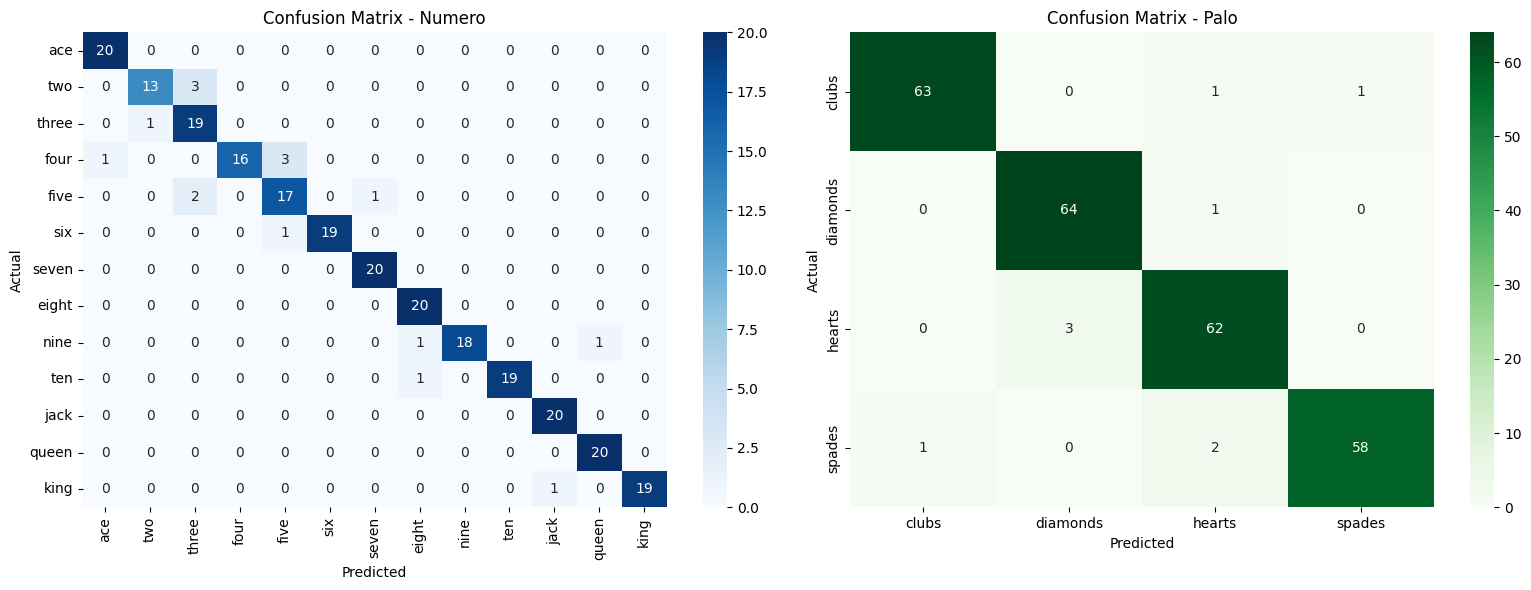

In [24]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Numero
cm_num = confusion_matrix(all_num_true, all_num_pred)
sns.heatmap(cm_num, annot=True, fmt='d', cmap='Blues', 
            xticklabels=num_names_list, yticklabels=num_names_list, ax=axes[0])
axes[0].set_title('Confusion Matrix - Numero')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Palo
cm_suit = confusion_matrix(all_suit_true, all_suit_pred)
sns.heatmap(cm_suit, annot=True, fmt='d', cmap='Greens',
            xticklabels=suit_names_list, yticklabels=suit_names_list, ax=axes[1])
axes[1].set_title('Confusion Matrix - Palo')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(os.path.join(path_results, name + '_confusion_matrices.png'), dpi=150)
plt.show()